# Discretization with decision trees 

* Definition
    * Discretization with Decision Trees consists of using a dicision tree to identify the optimal bins 
    * When a decision tree makes a decision, it assigns an observation to one of n end leaves 
    * Decision tree creates a discrete output, whose values are the predictions at each of its n leaves 
    * Replace the value with the mean target value (prediction)

* How to do discretization with trees? 
  * Train a decision tree of limited depth (2, 3, or 4) using the variable we want to discretize and the target 
  * Replace the values by the output returned by the tree 
  
* Advantages  
  * The output returned by the decision tree is monotonically related to the target 
  * The tree end nodes, or bins in the discretized variable show decreased entropy: that is, the observations within each bin are more similar among themselves than to those of other bins 

* Limitations 
  * Prone to overfitting 
  * Some tuning of the tree parameters needed to obtain the optimal number of splits (e.g. tree depth, minimum number of samples in one partition, maximum number of partitions, and a minimum information gain). This can be time consuming.
  
* Summary 
    * Does not improve value spread 
    * Handles outliers, trees are robus to outliers 
    * Creates discrete variable 
    * Creates monotonic relationship

# Prepare data

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [2]:
df = pd.read_csv('../data/house_price/train.csv', index_col='Id')

In [3]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
num_cols = df.drop('SalePrice', axis=1).select_dtypes('number').columns
num_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [5]:
len(num_cols)

36

# Select feature to experiment

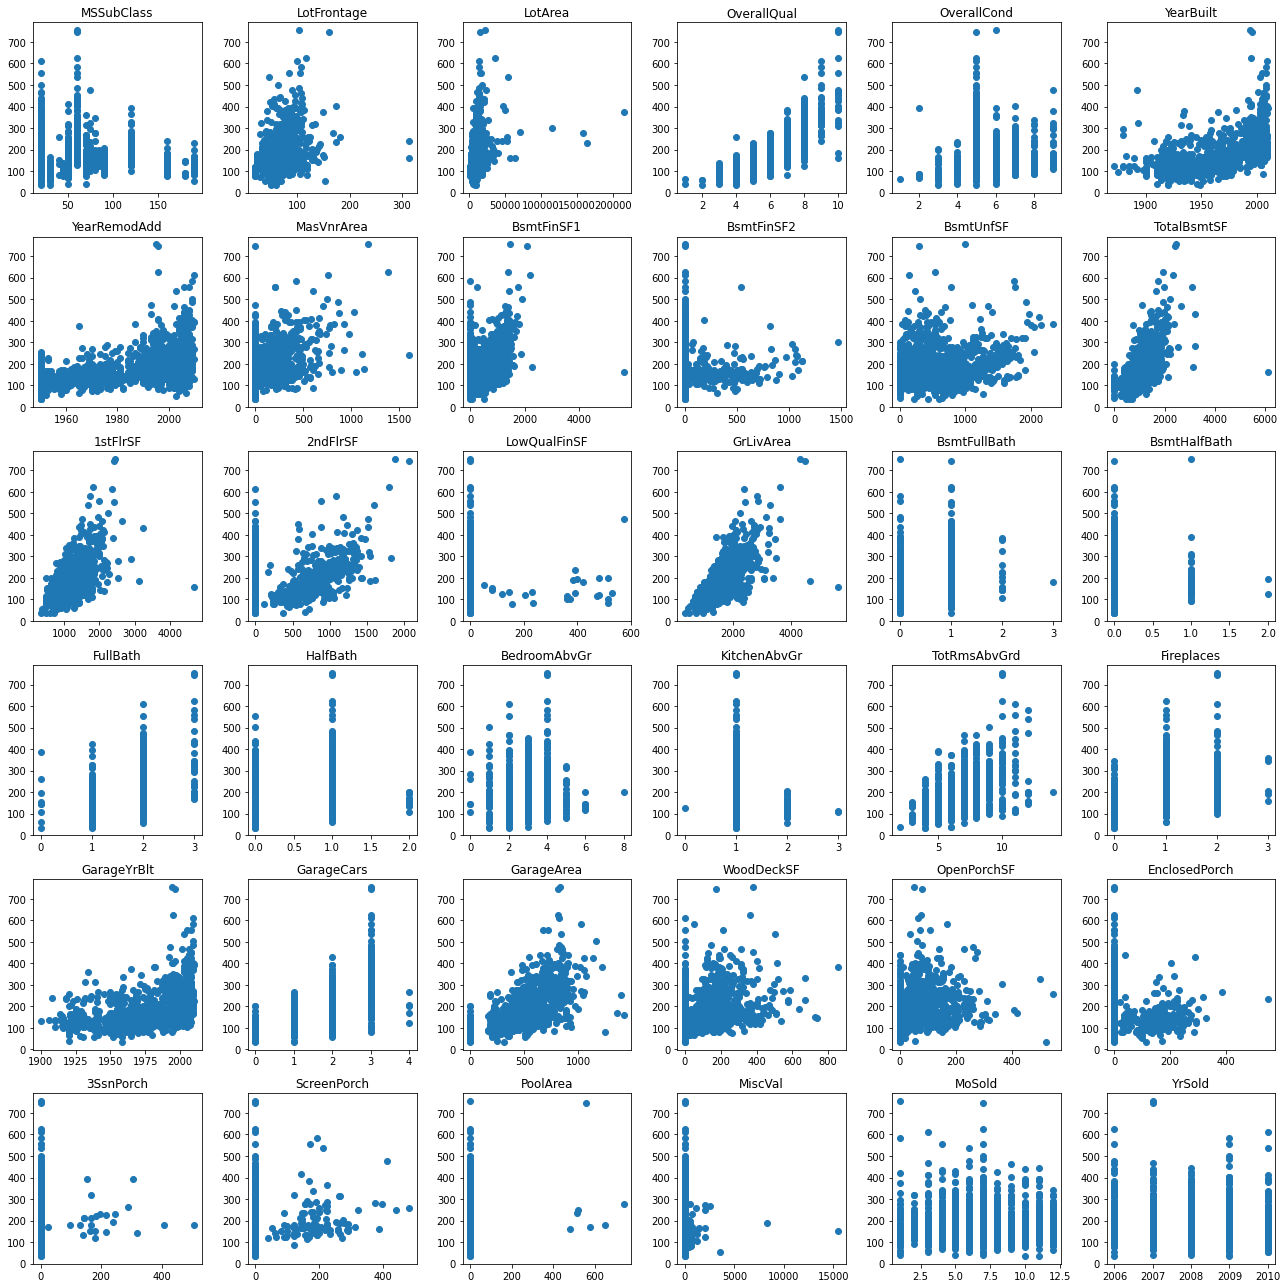

In [6]:
fig, axes = plt.subplots(6, 6, figsize=(18, 18))

for i in range(len(num_cols)):
    col_name = num_cols[i]
    row, col = i//6, i%6

    ax = axes[row, col]
    ax.scatter(df[col_name], df['SalePrice']/1000)
    ax.set_title(col_name)

plt.tight_layout()
plt.show()


In [7]:
col = 'MSSubClass'
new_col = col+'_tree'

In [8]:
df[col].isna().mean()

0.0

# Split data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df[col].to_frame(),
                                                    df['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)

X_train.shape, X_test.shape

((1022, 1), (438, 1))

# Train a decision tree 

In [10]:
tree_model = DecisionTreeRegressor(max_depth=3)

tree_model.fit(X_train[col].to_frame(), y_train)

DecisionTreeRegressor(max_depth=3)

In [11]:
X_train[new_col] = tree_model.predict(X_train[col].to_frame())

In [12]:
X_train.head()

,MSSubClass,MSSubClass_tree
Id,,
65,60,240141.297674
683,120,170744.233503
961,20,183289.530504
1385,50,140972.814159
1101,30,95839.361702


In [13]:
# let's explore how many end leaves the tree created 
X_train[new_col].unique()

array([240141.29767442, 170744.23350254, 183289.53050398, 140972.81415929,
        95839.36170213, 133665.78082192])

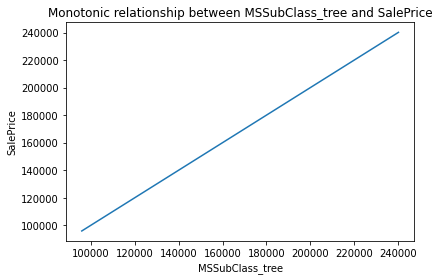

In [14]:
# monotonic relationship with target 
pd.concat([X_train, y_train], axis=1).groupby([new_col])['SalePrice'].mean().plot()
plt.title(f'Monotonic relationship between {new_col} and SalePrice')
plt.ylabel('SalePrice')
plt.tight_layout()

<AxesSubplot:xlabel='MSSubClass_tree'>

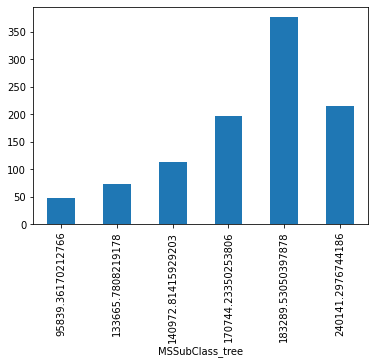

In [15]:
# numbmer of houses per bin 

X_train.groupby(new_col)[new_col].count().plot.bar()

<AxesSubplot:xlabel='MSSubClass_tree'>

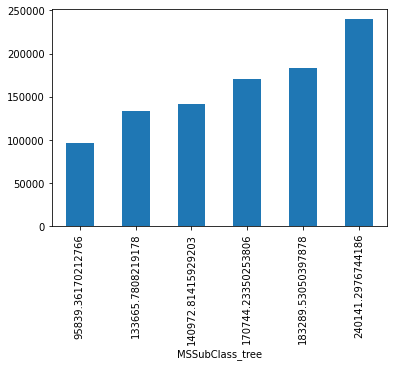

In [16]:
# median house price by bin 

X_train.groupby(new_col)[new_col].median().plot.bar()

In [17]:
# limits of buckets 

pd.concat([X_train.groupby(new_col)[col].min(), X_train.groupby(new_col)[col].max()], axis=1, keys=['min', 'max'])

,min,max
MSSubClass_tree,,
95839.361702,30,30
133665.780822,160,190
140972.814159,40,50
170744.233503,70,120
183289.530504,20,20
240141.297674,60,60


# Tree visualization

### (1) Using sklearn plot_tree

In [18]:
from sklearn.tree import plot_tree
from sklearn import tree

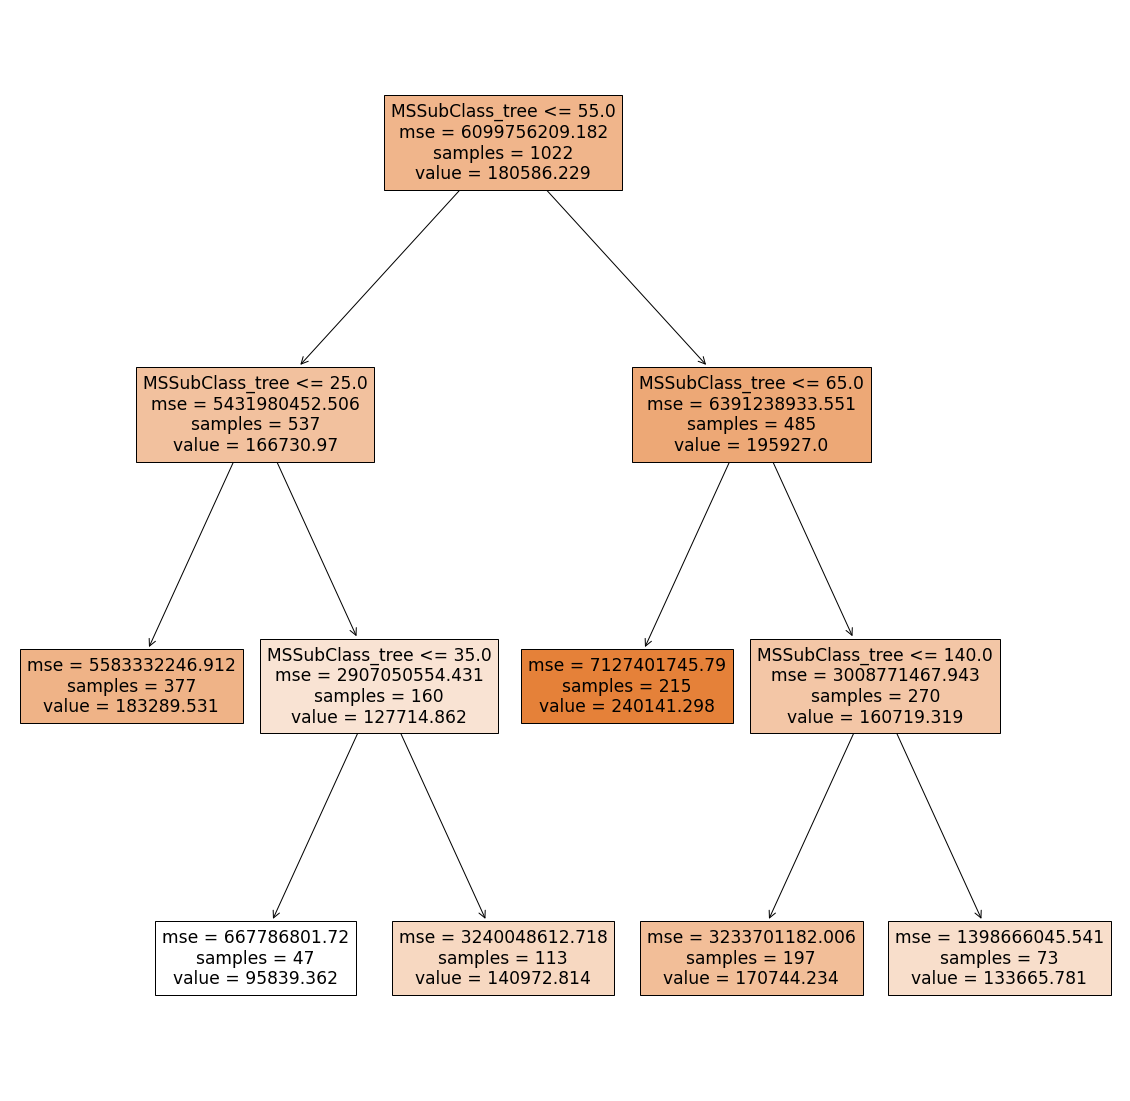

In [19]:
fig = plt.figure(figsize=(20,20))
tree.plot_tree(tree_model, feature_names=[new_col], filled=True)

fig.savefig('imagename.png')

### (2) Using export_graphviz

In [20]:
# export the tree as a file 
with open('tree_model.txt', 'w') as f:
    f = export_graphviz(tree_model, out_file=f, feature_names=[new_col], filled=True)

# if you open the file, it will look like this
"""
digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="MSSubClass_tree <= 55.0\nmse = 6099756209.182\nsamples = 1022\nvalue = 180586.229", fillcolor="#f0b58b"] ;
1 [label="MSSubClass_tree <= 25.0\nmse = 5431980452.506\nsamples = 537\nvalue = 166730.97", fillcolor="#f2c19e"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="mse = 5583332246.912\nsamples = 377\nvalue = 183289.531", fillcolor="#efb387"] ;
1 -> 2 ;
3 [label="MSSubClass_tree <= 35.0\nmse = 2907050554.431\nsamples = 160\nvalue = 127714.862", fillcolor="#f9e3d3"] ;
1 -> 3 ;
4 [label="mse = 667786801.72\nsamples = 47\nvalue = 95839.362", fillcolor="#ffffff"] ;
3 -> 4 ;
5 [label="mse = 3240048612.718\nsamples = 113\nvalue = 140972.814", fillcolor="#f7d8c1"] ;
3 -> 5 ;
6 [label="MSSubClass_tree <= 65.0\nmse = 6391238933.551\nsamples = 485\nvalue = 195927.0", fillcolor="#eda876"] ;
0 -> 6 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
7 [label="mse = 7127401745.79\nsamples = 215\nvalue = 240141.298", fillcolor="#e58139"] ;
6 -> 7 ;
8 [label="MSSubClass_tree <= 140.0\nmse = 3008771467.943\nsamples = 270\nvalue = 160719.319", fillcolor="#f3c6a6"] ;
6 -> 8 ;
9 [label="mse = 3233701182.006\nsamples = 197\nvalue = 170744.234", fillcolor="#f2be98"] ;
8 -> 9 ;
10 [label="mse = 1398666045.541\nsamples = 73\nvalue = 133665.781", fillcolor="#f8decb"] ;
8 -> 10 ;
}
"""



'\ndigraph Tree {\nnode [shape=box, style="filled", color="black"] ;\n0 [label="MSSubClass_tree <= 55.0\nmse = 6099756209.182\nsamples = 1022\nvalue = 180586.229", fillcolor="#f0b58b"] ;\n1 [label="MSSubClass_tree <= 25.0\nmse = 5431980452.506\nsamples = 537\nvalue = 166730.97", fillcolor="#f2c19e"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="mse = 5583332246.912\nsamples = 377\nvalue = 183289.531", fillcolor="#efb387"] ;\n1 -> 2 ;\n3 [label="MSSubClass_tree <= 35.0\nmse = 2907050554.431\nsamples = 160\nvalue = 127714.862", fillcolor="#f9e3d3"] ;\n1 -> 3 ;\n4 [label="mse = 667786801.72\nsamples = 47\nvalue = 95839.362", fillcolor="#ffffff"] ;\n3 -> 4 ;\n5 [label="mse = 3240048612.718\nsamples = 113\nvalue = 140972.814", fillcolor="#f7d8c1"] ;\n3 -> 5 ;\n6 [label="MSSubClass_tree <= 65.0\nmse = 6391238933.551\nsamples = 485\nvalue = 195927.0", fillcolor="#eda876"] ;\n0 -> 6 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n7 [label="mse = 71274017

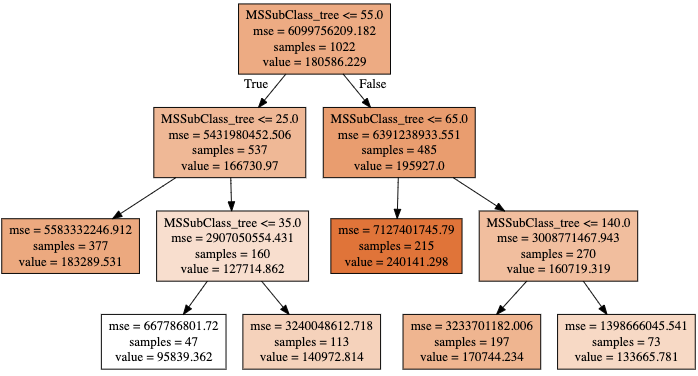

In [21]:
# Go to one of these oneline graph converter to generate a graph using the text 
# http://www.webgraphviz.com/ 
# https://dreampuf.github.io/GraphvizOnline/

# display here 
from IPython.display import Image

Image(filename='graphviz.png')

# Check monotonicity in test dataset

In [22]:
X_test[new_col] = tree_model.predict(X_test)

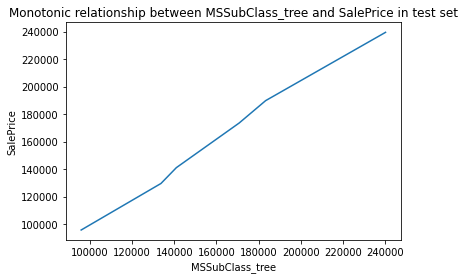

In [23]:
fig, ax = plt.subplots()
pd.concat([X_test, y_test], axis=1).groupby(new_col)['SalePrice'].mean().plot()
plt.title(f'Monotonic relationship between {new_col} and SalePrice in test set')
plt.ylabel('SalePrice')
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error, mean_squared_error


In [25]:
# R2 

r2_train = tree_model.score(X_train[col].to_frame(), y_train)
r2_test = tree_model.score(X_test[col].to_frame(), y_test)

print(f"train r2: {round(r2_train, 2)}, test r2: {round(r2_test, 2)}")

train r2: 0.23, test r2: 0.21


In [26]:
# mean squared error 

y_train_pred = tree_model.predict(X_train[col].to_frame())
y_test_pred = tree_model.predict(X_test[col].to_frame())

print(f"train MSE: {round(mean_squared_error(y_train_pred, y_train)**0.5, 2)}")
print(f"test MSE: {round(mean_squared_error(y_test_pred, y_test)**0.5, 2)}")


train MSE: 68346.14
test MSE: 73459.81


# Find the optimal tree (if non-monotonic)

In [27]:
from sklearn.model_selection import GridSearchCV

In [61]:
params = {
    'max_depth': (1,2,3,4),
    'min_samples_split': range(10, 100, 10),
    'min_samples_leaf'
}

tree_model = GridSearchCV(DecisionTreeRegressor(), 
                          params, 
                          scoring='neg_root_mean_squared_error',
                          return_train_score=True)

In [62]:
tree_model.fit(X_train[col].to_frame(), y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': (1, 2, 3, 4),
                         'min_samples_split': range(10, 100, 10)},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [63]:
pd.DataFrame(tree_model.cv_results_)\
[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']]

,params,mean_train_score,mean_test_score,rank_test_score
0,"{'max_depth': 1, 'min_samples_split': 10}",-76653.331326,-77089.964314,28
1,"{'max_depth': 1, 'min_samples_split': 20}",-76653.331326,-77089.964314,28
2,"{'max_depth': 1, 'min_samples_split': 30}",-76653.331326,-77089.964314,28
3,"{'max_depth': 1, 'min_samples_split': 40}",-76653.331326,-77089.964314,28
4,"{'max_depth': 1, 'min_samples_split': 50}",-76653.331326,-77089.964314,28
5,"{'max_depth': 1, 'min_samples_split': 60}",-76653.331326,-77089.964314,28
6,"{'max_depth': 1, 'min_samples_split': 70}",-76653.331326,-77089.964314,28
7,"{'max_depth': 1, 'min_samples_split': 80}",-76653.331326,-77089.964314,28
8,"{'max_depth': 1, 'min_samples_split': 90}",-76653.331326,-77089.964314,28
9,"{'max_depth': 2, 'min_samples_split': 10}",-69896.462882,-69999.570420,19


In [64]:
tree_model.best_estimator_

DecisionTreeRegressor(max_depth=4, min_samples_split=30)

In [65]:
-tree_model.best_score_

68224.61070678374

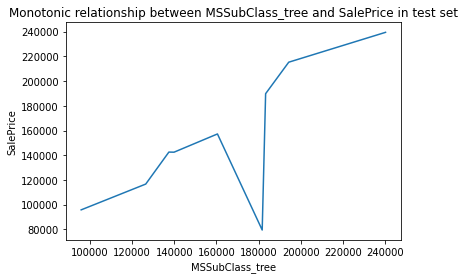

In [42]:
X_test[new_col] = tree_model.predict(X_test[col].to_frame())

fig, ax = plt.subplots()
pd.concat([X_test, y_test], axis=1).groupby(new_col)['SalePrice'].mean().plot()
plt.title(f'Monotonic relationship between {new_col} and SalePrice in test set')
plt.ylabel('SalePrice')
plt.show()